In [41]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggstream)
library(geomtextpath)
library(bbplot)
source('/home//jupyter/BRI_Figures_Final_V2/helper_function/helper_function_IHA.r')

In [42]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [43]:
df<-read.csv("03_Get_Counts/SF4_Freq.csv")

In [45]:
selected_celltype<-c('Core naive CD8 T cell',
                     'CM CD8 T cell',
                     'KLRF1- GZMB+ CD27- EM CD8 T cell',
                     'KLRF1+ GZMB+ CD27- EM CD8 T cell',
                     'GZMK+ CD27+ EM CD8 T cell',
                     'GZMK- CD27+ EM CD8 T cell')

In [46]:
df_subset<-df%>% filter(celltypist_l3 %in% selected_celltype)

In [47]:
df_subset<-df_subset %>%
  dplyr::group_by(pbmc_sample_id) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(pbmc_sample_id) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% 
  dplyr::ungroup() %>% as.data.frame(.)

In [48]:
options(repr.plot.width = 100/25.4, repr.plot.height = 35/25.4)
 df_subset<-df_subset%>%
  dplyr::group_by(celltypist_l3)%>%  
mutate(temp_label = if_else(Ages == max(Ages), as.character(celltypist_l3), NA_character_)) %>%
  group_by(temp_label) %>%
  mutate(label = if_else(row_number() == 1 & !is.na(temp_label), temp_label, NA_character_)) %>%
  ungroup() %>%
  select(-temp_label)

p<-ggplot(data = df_subset ,
            aes(x = Ages, y = percentage_clr,,color=celltypist_l3,group=celltypist_l3)) +
  geom_smooth( se = TRUE, linewidth = 0.5)+
  theme_classic(base_size = 6) + 
  geom_label_repel(aes(label = label),size=1,nudge_x = 15,  segment.linetype = 4,
  segment.color = 'grey',
                  na.rm = TRUE)+
  theme(legend.position = "none")+
  scale_color_manual(values = color_vector) 
p

ggsave('test.pdf',p,width = 100/25.4,height = 35/25.4)


ERROR: Error in geom_label_repel(aes(label = label), size = 1, nudge_x = 15, : could not find function "geom_label_repel"


In [49]:
df_subset<-df_subset %>%
  dplyr::group_by(Ages,celltypist_l3) %>%     
summarize(mean_count=mean(count)) %>% dplyr::group_by(Ages) %>%     
  dplyr::mutate(percentage = (mean_count / sum(mean_count)) ) 

`summarise()` has grouped output by 'Ages'. You can override using the
`.groups` argument.


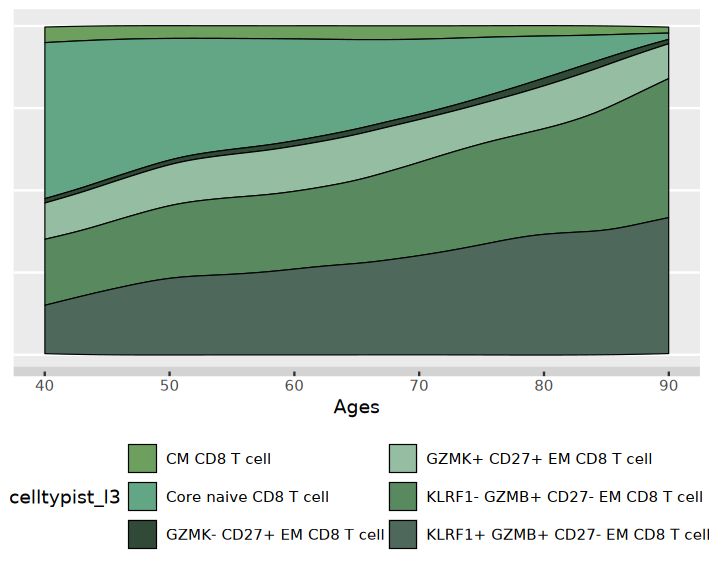

In [50]:
options(repr.plot.width = 150/25.4, repr.plot.height = 120/25.4)

p<-ggplot(df_subset ,aes(x = Ages, 
             y = percentage,
             group = celltypist_l3,
             fill = celltypist_l3)) +
  ggstream::geom_stream(color = 'black', 
                        lwd = 0.25,
                        bw = 1) + 

  scale_fill_manual(values = color_vector) + 
 
theme(legend.position = "bottom")+guides(fill=guide_legend(ncol=2))+
  theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.border = element_blank(),
        axis.line.x = element_line(size = 2, linetype = "solid", colour = "lightgrey"),
        axis.line.y = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank())


p
ggsave('FigureD-1.pdf',p,width = 100/25.4,height = 60/25.4)


In [51]:
selected_celltype<-c('CM CD4 T cell',
                     'GZMB- CD27+ EM CD4 T cell',
                     'GZMB- CD27- EM CD4 T cell',
                     'Core naive CD4 T cell',
                     'KLRF1- GZMB+ CD27- memory CD4 T cell')

In [52]:
df_subset<-df%>% filter(celltypist_l3 %in% selected_celltype)

In [53]:
df_subset<-df_subset %>%
  dplyr::group_by(pbmc_sample_id) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(pbmc_sample_id) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% 
  dplyr::ungroup() %>% as.data.frame(.)

`geom_smooth()` using formula = 'y ~ x'


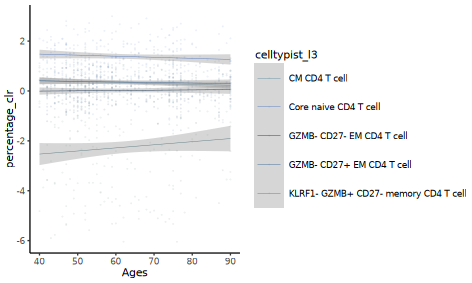

In [54]:
options(repr.plot.width = 100/25.4, repr.plot.height = 60/25.4)

ggplot(data = df_subset ,
            aes(x = Ages, y = percentage_clr,,color=celltypist_l3,group=celltypist_l3)) +
  geom_point(size = 0.1, alpha=0.1,stroke = 0.1) +
  geom_smooth(method = 'lm', se = TRUE, linewidth = 0.1)+
  theme_classic(base_size = 6)+
  scale_color_manual(values = color_vector) 

In [56]:
df_subset<-df_subset %>%
  dplyr::group_by(Ages,celltypist_l3) %>%     
summarize(mean_count=mean(count)) %>% dplyr::group_by(Ages) %>%     
  dplyr::mutate(percentage = (mean_count / sum(mean_count)) ) 

`summarise()` has grouped output by 'Ages'. You can override using the
`.groups` argument.


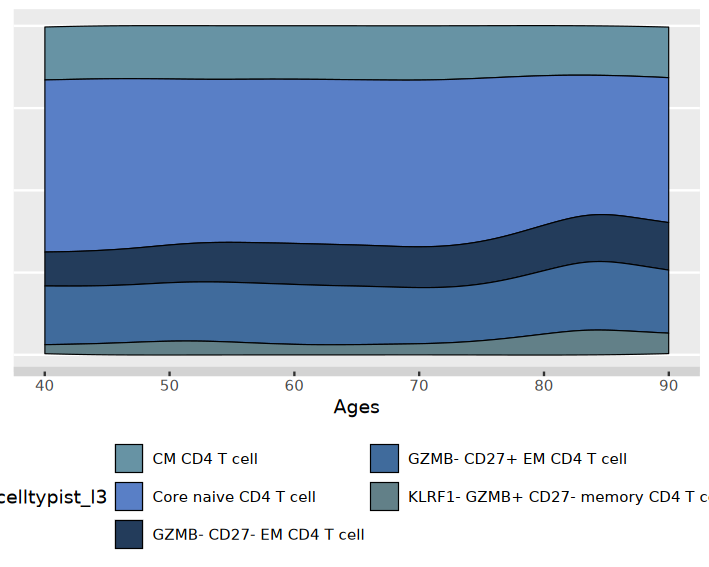

In [57]:
options(repr.plot.width = 150/25.4, repr.plot.height = 120/25.4)

p<-ggplot(df_subset ,aes(x = Ages, 
             y = percentage,
             group = celltypist_l3,
             fill = celltypist_l3)) +
  ggstream::geom_stream(color = 'black', 
                        lwd = 0.25,
                        bw = 1) + 
  scale_fill_manual(values = color_vector) + 
theme(legend.position = "bottom")+guides(fill=guide_legend(ncol=2))+
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.border = element_blank(),
        axis.line.x = element_line(size = 2, linetype = "solid", colour = "lightgrey"),
        axis.line.y = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank())


p
ggsave('FigureD-2.pdf',p,width = 100/25.4,height = 60/25.4)
